<a href="https://colab.research.google.com/github/Kridr/HW_OSDA_HSE/blob/main/HW5_OSDA/NeuralFCA_OSDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fcapy==0.1.4.1
!pip install frozendict
!pip install ipynb
!pip install sparselinear
!pip install bitsets
!pip install bitarray

!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 2.9 MB/s 
Looking in i

In [2]:
!rm neural_lib.py
!wget https://raw.githubusercontent.com/EgorDudyrev/OSDA_course/Autumn_2022/neural_fca/neural_lib.py

rm: cannot remove 'neural_lib.py': No such file or directory
--2022-12-12 08:42:02--  https://raw.githubusercontent.com/EgorDudyrev/OSDA_course/Autumn_2022/neural_fca/neural_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7262 (7.1K) [text/plain]
Saving to: ‘neural_lib.py’

neural_lib.py       100%[===================>]   7.09K  --.-KB/s    in 0s      

2022-12-12 08:42:02 (56.7 MB/s) - ‘neural_lib.py’ saved [7262/7262]



In [3]:
import pandas as pd
import numpy as np

from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice

from sklearn.model_selection import train_test_split
from sklearn import metrics

import neural_lib as nl

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/Kridr/HW_OSDA_HSE/main/NeuralFCA_OSDA/wind_dataset.csv')
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [5]:
df.describe()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
count,6574.000000,6574.000000,6574.000000,6513.000000,5953.000000,6513.000000,5900.000000,6214.000000
mean,9.796834,0.391542,1.885169,0.356364,13.339123,0.464456,6.411678,2.736547
std,4.977272,1.179092,4.030529,1.128552,4.890546,1.177571,4.637243,5.569175
min,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,-11.500000,-14.400000
25%,6.000000,0.000000,0.000000,0.000000,9.600000,0.000000,3.000000,-1.000000
50%,9.210000,0.000000,0.200000,0.000000,13.300000,0.000000,6.500000,3.000000
75%,12.960000,0.000000,2.000000,0.000000,17.200000,0.000000,10.000000,7.000000
max,30.370000,4.000000,67.000000,4.000000,26.800000,4.000000,18.000000,15.800000


Whether column has nan values?

In [6]:
df.isna().any()

DATE       False
WIND       False
IND        False
RAIN       False
IND.1       True
T.MAX       True
IND.2       True
T.MIN       True
T.MIN.G     True
dtype: bool

Binarization of our target variable

In [7]:
df['WIND'] = np.where(df['WIND'] >= 23 / 1.151, True, False)
df['DATE'] = pd.to_datetime(df['DATE'])

Creating X and y. As long as it is impossible to create lattices using all objects, we need limit them. At this point I do some cheat, because I increase the ratio of positive classes

In [8]:
FULL_SIZE = 60 #I NEED TO USE EXTREMELY SMALL DATASETS BECAUSE OF SLOW LATTICE CREATION
RATIO = 0.5 #RATIO OF POSITIVE CLASSES

pos_size = int(FULL_SIZE * RATIO)
neg_size = int(FULL_SIZE * (1 - RATIO))

df_temp = pd.concat([
        df[df['WIND']].sample(pos_size, random_state=5),
        df[~df['WIND']].sample(neg_size, random_state=5)
    ],
    ignore_index=True
)
X = df_temp.drop(columns=['WIND'])
y = df_temp['WIND']

Splitting data into train and test. We use such way because we can see that we have partially time-series data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=5)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_train.index = X_train.index.astype(str)
y_train.index = y_train.index.astype(str)

X_test.index = X_test.index.astype(str)
y_test.index = y_test.index.astype(str)

#Binarization of data

We have three types of features:
1. Categories
2. Numbers
3. Dates

First, we create a binarizer for categories. It will helps us further.


In this case the only choice we have is to use One Hot Encoding. Other methods do not return binary features

The next step is numbers. In this case we can create interval features from numbers and then treat intervals we got as categorical features.

In this case we can vary the number of intervals

The last step is dates. I assume that year attribute is not valuable, so we will just consider months and days. The idea of binarization here is to treat months and days like numbers

We can vary number of intervals for days and for months

Let's wrap it up into one class to make it easier for further searching of the best binarization strategy

In [10]:
class BinarizerWindSpeedDataset():
    def __init__(self, month_bins, day_bins, rain_bins, tmax_bins, tmin_bins, tming_bins):
        self.month_bins = month_bins
        self.day_bins = day_bins
        self.rain_bins = rain_bins
        self.tmax_bins = tmax_bins
        self.tmin_bins = tmin_bins
        self.tming_bins = tming_bins

        self.was_fit = False

    def fit_transform(self, X):
        X_f = self.fillna(X)

        df_date, self.month_interval_bins, self.day_interval_bins = self.dates_binarizer(X_f['DATE'], self.month_bins, self.day_bins)

        df_ind = self.categories_binarizer(X_f['IND'])
        df_ind1 = self.categories_binarizer(X_f['IND.1'])
        df_ind2 = self.categories_binarizer(X_f['IND.2'])

        df_rain, self.rain_interval_bins = self.numbers_binarizer(X_f['RAIN'], self.rain_bins)
        df_tmax, self.tmax_interval_bins = self.numbers_binarizer(X_f['T.MAX'], self.tmax_bins)
        df_tmin, self.tmin_interval_bins = self.numbers_binarizer(X_f['T.MIN'], self.tmin_bins)
        df_tming, self.tming_interval_bins = self.numbers_binarizer(X_f['T.MIN.G'], self.tming_bins)

        self.was_fit = True

        df_fit_ret =  pd.concat([
                df_date,
                df_ind,
                df_ind1,
                df_ind2,
                df_rain,
                df_tmax,
                df_tmin,
                df_tming
            ],
            axis=1
        )

        self.df_fit_ret_columns = df_fit_ret.columns

        return df_fit_ret
        
    def transform(self, X):
        if not self.was_fit:
            raise RuntimeError('Fit train data first!')

        X_f = self.fillna(X)

        df_date, _, _ = self.dates_binarizer(X_f['DATE'], self.month_interval_bins, self.day_interval_bins)

        df_ind = self.categories_binarizer(X_f['IND'])
        df_ind1 = self.categories_binarizer(X_f['IND.1'])
        df_ind2 = self.categories_binarizer(X_f['IND.2'])

        df_rain, _ = self.numbers_binarizer(X_f['RAIN'], self.rain_interval_bins)
        df_tmax, _ = self.numbers_binarizer(X_f['T.MAX'], self.tmax_interval_bins)
        df_tmin, _ = self.numbers_binarizer(X_f['T.MIN'], self.tmin_interval_bins)
        df_tming, _ = self.numbers_binarizer(X_f['T.MIN.G'], self.tming_interval_bins)

        self.was_fit = True

        df_tr_ret = pd.concat([
                df_date,
                df_ind,
                df_ind1,
                df_ind2,
                df_rain,
                df_tmax,
                df_tmin,
                df_tming
            ],
            axis=1
        )

        cols_to_add = list(set(self.df_fit_ret_columns) - set(df_tr_ret.columns))
        for col in cols_to_add:
            df_tr_ret[col] = False

        return df_tr_ret

    def fillna(self, X):
        X_c = X.copy()

        X_c['IND.1'] = X_c['IND.1'].fillna(0)
        X_c['IND.2'] = X_c['IND.2'].fillna(0)

        X_c['T.MAX'] = X_c['T.MAX'].fillna(X_c['T.MAX'].mean())
        X_c['T.MIN'] = X_c['T.MIN'].fillna(X_c['T.MIN'].mean())
        X_c['T.MIN.G'] = X_c['T.MIN.G'].fillna(X_c['T.MIN.G'].mean())

        return X_c

    def categories_binarizer(self, s):
        #CAUTION: WITH drop_first=True WE CANNOT COVER ALL THE OBJECTS FROM TRAIN
        #HOWEVER WE USE LESS FEATURES AND THEREFORE WE CAN CALCULATE CONCEPTS FASTER
        #(CONCEPTS ARE CALCULATED VERY SLOW)
        df_temp = pd.get_dummies(s, drop_first=True).astype(bool)
        df_temp.columns = [s.name + '_' + str(i) for i in range(len(df_temp.columns))]
        return df_temp

    def numbers_binarizer(self, s, bins):
        temp, interval_bins = pd.cut(s, bins, retbins=True)
        return self.categories_binarizer(temp), interval_bins

    def dates_binarizer(self, s, month_bins, day_bins):
        s_m = s.dt.month
        s_m.name = 'MONTH'

        s_d = s.dt.day
        s_d.name = 'DAYS'

        df_month, month_interval_bins = self.numbers_binarizer(s_m, month_bins)
        df_day, day_interval_bins = self.numbers_binarizer(s_d, day_bins)

        return pd.concat([df_month, df_day], axis=1), month_interval_bins, day_interval_bins


# Baseline

In [11]:
bwsd = BinarizerWindSpeedDataset(month_bins=2, day_bins=2, rain_bins=2, tmax_bins=2, tmin_bins=2, tming_bins=2)
X_train_bin = bwsd.fit_transform(X_train)
X_train_bin.head()

,MONTH_0,DAYS_0,IND_0,IND.1_0,IND.1_1,IND.2_0,IND.2_1,RAIN_0,T.MAX_0,T.MIN_0,T.MIN.G_0
0,True,False,False,False,False,False,False,False,False,True,True
1,False,False,False,False,True,False,True,True,True,True,False
2,True,False,False,False,False,False,False,False,True,True,True
3,False,True,True,False,False,False,False,False,False,True,True
4,False,True,False,False,False,False,False,False,True,True,False


In [12]:
K_train = FormalContext.from_pandas(X_train_bin)

In [13]:
L = ConceptLattice.from_context(K_train, is_monotone=True)

In [14]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = metrics.f1_score(y_train, y_preds)

In [15]:
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:30])

#WE DO NOT USE ASSERTION BELOW, BECAUSE SOMEHOW IT IS IMPOSSIBLE TO COVER
#ALL THE OBJECTS FROM TRAIN SET (CHECK COMMENTS IN THE categories_binarizer function)
#assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

In [16]:
len({g_i for c in L[best_concepts] for g_i in c.extent_i})

37

In [17]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))

In [18]:
cn.fit(X_train_bin, y_train)

In [19]:
X_test_bin = bwsd.transform(X_test)

In [20]:
y_test_pred = cn.predict(X_test_bin)

In [21]:
y_test.astype(int).to_numpy(), y_test_pred

(array([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [22]:
metrics.f1_score(y_test, y_test_pred)

0.0

# Visualization

In [23]:
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = (1,1,1,1)

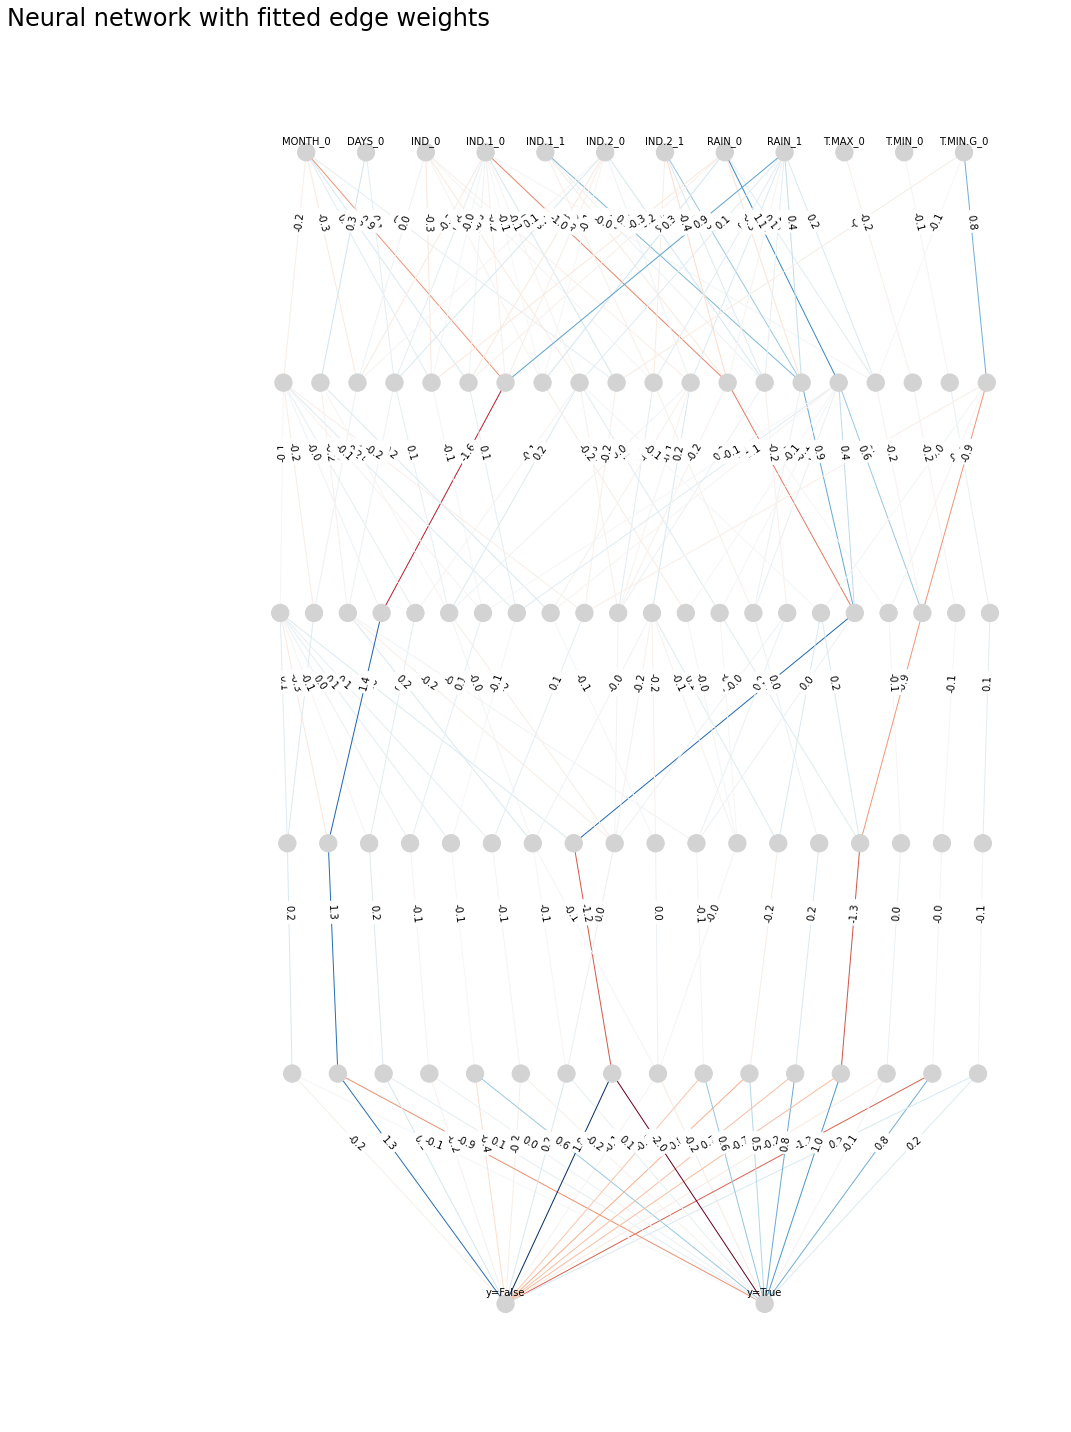

In [34]:
vis = LineVizNx(node_label_font_size=14, node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))+'\n\n')

vis.init_mover_per_poset(cn.poset)
mvr = vis.mover

import networkx as nx

fig, ax = plt.subplots(figsize=(15,20))

edge_weights = cn.edge_weights_from_network()

traced = cn.trace_description({'MONTH_0'}, include_targets=False)

vis.draw_poset(
    cn.poset, ax=ax, 
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes), only_new_attrs=True)+'\n\n',
    node_label_font_size=10,
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, x=0.05, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('fitted_network.png')
plt.show()

# Searching for best option

DISCLAIMER: DUE TO TIME LIMITS OF LATTICE CREATION I CANNOT RUN THE CODE IN THIS PART WITH FURTHER INTERRUPTION OF IT. BUT IT IS WORKING CODE

As an example of searching I provide several options for each hyperparameter. It is very poor set, but lattice creating is very long...

In [27]:
month_bins_list = [2, 3]
day_bins_list = [2, 3]
rain_bins_list = [2, 3]
#United temperature bins (just because lattices are constructed very slow)
t_bins_list = [2, 3]

In [28]:
best_params = {}
best_f1 = 0

for month_bins in month_bins_list:
    for day_bins in day_bins_list:
        for rain_bins in rain_bins_list:
            for t_bins in t_bins_list:
                params = {
                    'month_bins': month_bins, 
                    'day_bins': day_bins, 
                    'rain_bins': rain_bins, 
                    'tmax_bins': t_bins, 
                    'tmin_bins': t_bins, 
                    'tming_bins': t_bins
                }

                print(params)

                bwsd = BinarizerWindSpeedDataset(**params)
                X_train_bin = bwsd.fit_transform(X_train)
                K_train = FormalContext.from_pandas(X_train_bin)
                L = ConceptLattice.from_context(K_train, is_monotone=True)

                for c in L:
                    y_preds = np.zeros(K_train.n_objects)
                    y_preds[list(c.extent_i)] = 1
                    c.measures['accuracy'] = metrics.accuracy_score(y_train, y_preds)

                best_concepts_s = list(L.measures['accuracy'].argsort()[::-1][:20])
                cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train)))
                cn.fit(X_train_bin, y_train)

                X_test_bin = bwsd.transform(X_test)
                y_test_pred = cn.predict(X_test_bin)
                f1 = metrics.f1_score(y_test, y_test_pred)

                print(f'F1 = {f1}\n\n')
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = params

{'month_bins': 2, 'day_bins': 2, 'rain_bins': 2, 'tmax_bins': 2, 'tmin_bins': 2, 'tming_bins': 2}
F1 = 0.0


{'month_bins': 2, 'day_bins': 2, 'rain_bins': 2, 'tmax_bins': 3, 'tmin_bins': 3, 'tming_bins': 3}
F1 = 0.5333333333333333


{'month_bins': 2, 'day_bins': 2, 'rain_bins': 3, 'tmax_bins': 2, 'tmin_bins': 2, 'tming_bins': 2}
F1 = 0.625


{'month_bins': 2, 'day_bins': 2, 'rain_bins': 3, 'tmax_bins': 3, 'tmin_bins': 3, 'tming_bins': 3}


KeyboardInterrupt: ignored

# Comparing with State-Of-The-Art approach

As an ultimate opponent I would like to choose CatBoost

In [29]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 21 kB/s 


In [30]:
from catboost import CatBoostClassifier

Function for transforming data. It is needed to fit catboost

In [31]:
def cb_transform(df):
    df_c = df.copy()
    df_temp = pd.concat([
            df['DATE'].dt.year,
            df['DATE'].dt.month,
            df['DATE'].dt.day,
        ],
        axis=1
    ).astype(str)
    df_temp.columns = ['YEAR', 'MONTH', 'DAY']

    df_c.drop(columns=['DATE'], inplace=True)

    df_c = pd.concat([df_temp, df_c], axis=1)

    for col in ['IND', 'IND.1', 'IND.2']:
        df_c[col] = df_c[col].astype(str)
    return df_c

Fitting catboost classifier

In [32]:
clf = CatBoostClassifier(
    iterations=1000,
)

X_train_cb = cb_transform(X_train)
X_test_cb = cb_transform(X_test)

clf.fit(X_train_cb, y_train.astype(int), 
        cat_features=['YEAR', 'MONTH', 'DAY', 'IND', 'IND.1', 'IND.2'],
        verbose=False
)

F1 score

In [33]:
metrics.f1_score(y_test, clf.predict(X_test_cb))

0.7999999999999999